In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
HOME = os.path.expanduser("~")
sys.path.append(os.path.join(HOME, 'programming', 'pipeline_utility'))
from utilities.utilities_registration import start_plot, end_plot, update_multires_iterations, plot_values

Connecting dklab@192.168.1.12:3306


In [3]:
# Get a middle section image from DK52
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
fixed_filename = os.path.join(INPUT, '217.tif')
fixed = sitk.ReadImage(fixed_filename, sitk.sitkFloat32)

In [4]:
def register(fixed, moving):
    rotation_transform = sitk.CenteredTransformInitializer(
        fixed, moving,
        sitk.Similarity2DTransform())

    R2 = sitk.ImageRegistrationMethod()
    R2.SetInitialTransform(rotation_transform, inPlace=True)
    R2.SetMetricAsCorrelation() # -0439
    R2.SetMetricSamplingStrategy(R2.REGULAR) # random = 0.442 # regular -0.439
    R2.SetMetricSamplingPercentage(0.2)
    R2.SetOptimizerAsRegularStepGradientDescent(learningRate=1.0,
                                               minStep=1e-4,
                                               numberOfIterations=100,
                                               gradientMagnitudeTolerance=1e-8)
    #R2.SetOptimizerScalesFromPhysicalShift()
    R2.SetInterpolator(sitk.sitkLinear)
    R2.AddCommand(sitk.sitkStartEvent, start_plot)
    R2.AddCommand(sitk.sitkEndEvent, end_plot)
    R2.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
    R2.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R2))
    rotation_transform = R2.Execute(sitk.Cast(fixed, sitk.sitkFloat32),
                                                   sitk.Cast(moving, sitk.sitkFloat32))
    return rotation_transform



In [5]:
# create a drastic rotation and translation
mr = np.radians(40)
mx = 130.0
my = 100.0
transform = sitk.Euler2DTransform()
transform.SetCenter(np.array(fixed.GetSize()) / 2)
transform.SetAngle(mr)
transform.SetTranslation([mx, my])

In [6]:
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)
resample.SetDefaultPixelValue(0)
resample.SetOutputPixelType(fixed.GetPixelID())

Text(0.5, 1.0, 'Original image')

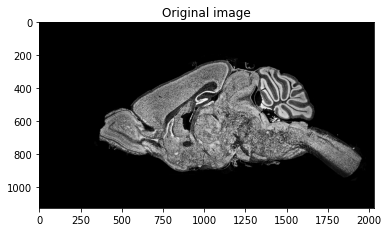

In [7]:
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.title('Original image')

Text(0.5, 1.0, 'Manually transformed image')

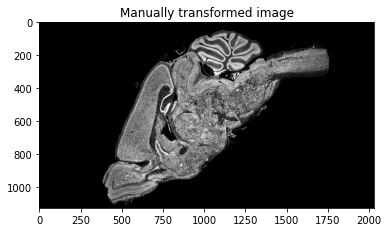

In [8]:
resample.SetTransform(transform)
transformed = resample.Execute(fixed)
plt.imshow(sitk.GetArrayViewFromImage(transformed), cmap='gray')
plt.title('Manually transformed image')

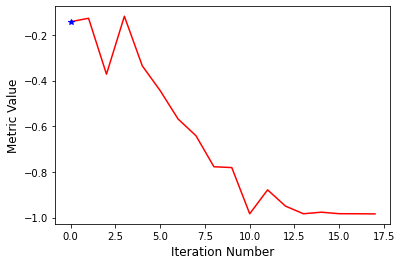

manual rotation, xshift, yshift 0.7 130.0 100.0
transf rotation, xshift, yshift -0.7 -165 -69 0.9999817167119677
Rotation is off by  0.00010467977003303375
X shift is off by  -34.819080394321446
Y shift is off by  31.457926378569383


In [11]:
# run transform with metrics displayed
final_transform = register(fixed, transformed)
finalParameters = final_transform.GetParameters()
scale, tr, tx, ty = finalParameters

print('manual rotation, xshift, yshift', round(mr,2), mx, my)
print('transf rotation, xshift, yshift', round(tr,2), round(tx), round(ty), scale)
print('Rotation is off by ', abs(mr) - abs(tr))
print('X shift is off by ', abs(mx) - abs(tx))
print('Y shift is off by ', abs(my) - abs(ty))

#print(finalParameters)

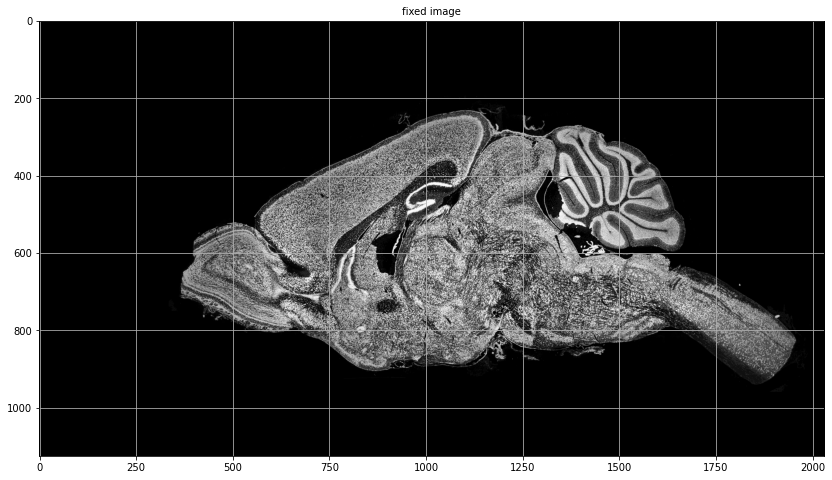

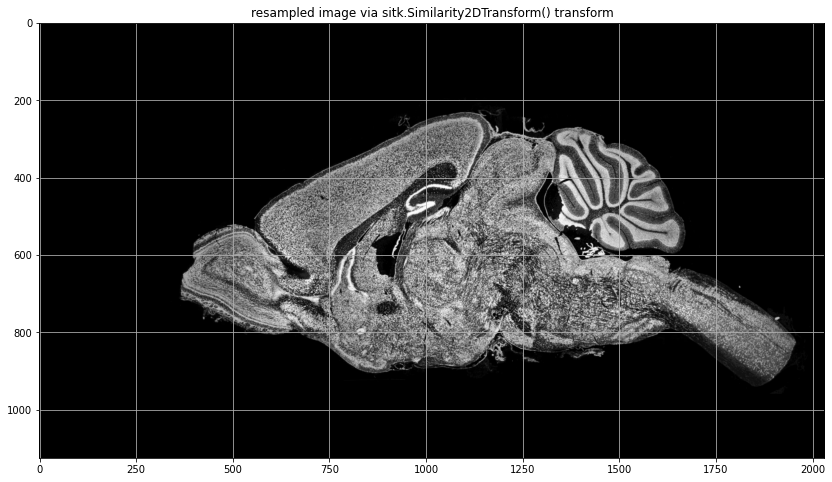

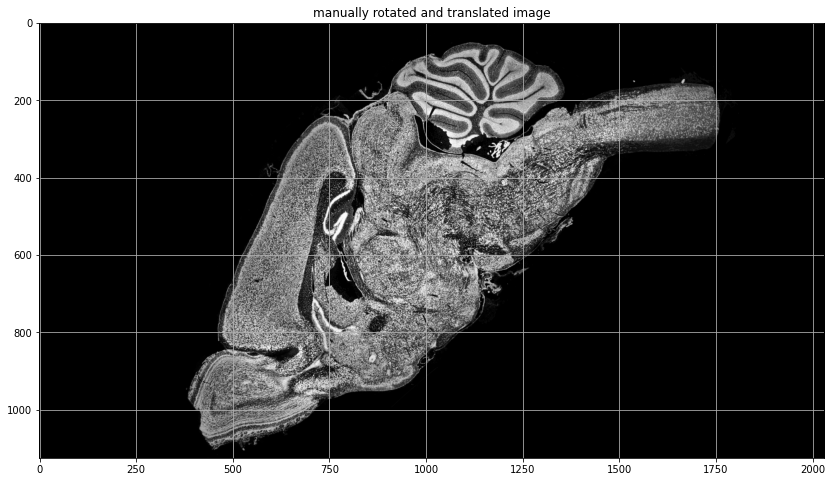

In [10]:
moving_resampled = sitk.Resample(transformed, fixed, final_transform, sitk.sitkLinear, 0.0, transformed.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.grid()
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.grid()
plt.title('resampled image via sitk.Similarity2DTransform() transform')

fig = plt.figure(figsize=(15, 8))
plt.title('manually rotated and translated image')
plt.grid()
plt.imshow(sitk.GetArrayViewFromImage(transformed), cmap='gray')
    